# How many repetitions are sufficiente for meaningful results?


Motivating example from [Werner et al. (2024)](https://arxiv.org/abs/2408.00426):

> To evaluate how many repetitions are necessary to obtain conclusive results in an AL experiment, we computed 100 runs of our top-performing AL method on one dataset. Our best method is margin sampling and we chose the Splice dataset for its average size and complexity. This allows us firstly, to obtain a very strong estimation of the “true” average performance of margin sampling on this dataset and secondly, to draw subsets from this pool of 100 runs. Setting the size of our draws to α and sampling uniformly, we can approximate a cross-validation process with α repetitions. Each of these draws can be interpreted as a reported result in AL literature where the authors employed α repetitions. Figure 1 shows the “true” mean performance of margin sampling (green) in relation to random sampling (black) and the oracle performance (red). We display 5 random draws of size α in blue. We can observe that even for a relatively high number of repetitions the variance between the samples is extremely high, resulting in some performance curves being worse than random and some being significantly better. When setting α = 50 we observe all samples to converge close to the true mean performance.

Main evalutation from [Werner et al. (2024)](https://arxiv.org/abs/2408.00426):

>  In addition to this motivating example, we carried out our main evaluation (Tab. 3) multiple times by sampling 3 from our available runs uniformly at random and comparing the results. We found significant differences in the performance of AL methods on individual datasets, as well as permutations in the final ranking. This partly explains the ongoing difficulties in reproducing results for AL experiments and benchmarks. The details can be found in App. C. For this benchmark we employ 50 repetitions of every experiment.

What to do:

1. Choose AL top-perfoming method
2. Choose a dataset with average **size** and **complexity**
3. Execute for 100 runs

## Imports

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Datasets

In [2]:
DATA_PATH = "../datasets/"

In [3]:
dataset_name = []
n_instances = []
n_classes = []
for dataset in open(os.path.join(DATA_PATH, "datasets.txt")):
    csv_file = f'{dataset.strip()}.csv'
    csv_path = os.path.join(DATA_PATH, "csv", csv_file)

    df = pd.read_csv(csv_path)
    
    dataset_name.append(dataset.strip())
    n_instances.append(df.shape[0])
    n_classes.append(len(df.iloc[:, -1].unique()))

data_df = pd.DataFrame({'dataset_name': dataset_name, 'n_instances': n_instances, 'n_classes': n_classes})

Estatísitcas dos conjuntos de dados:

In [4]:
data_df.n_instances.mean(), data_df.n_classes.mean()

(2735.3, 4.222222222222222)

### Recuperando resultados

In [5]:
RESULTS_PATH = '../results/'

### Selecionar dataset representativo do conjunto

In [6]:
data_df['distance_to_mean'] = np.sqrt( (data_df.n_instances - data_df.n_instances.mean())**2  + (data_df.n_classes - data_df.n_classes.mean())**2)
data_df.sort_values(by='distance_to_mean').head()

,dataset_name,n_instances,n_classes,distance_to_mean
45,ozone-eighthr,2534,2,201.312266
62,statlog-image-segmentation,2310,7,425.309071
70,thyroid-sick-euthyroid,3163,2,427.705773
68,thyroid-hypothyroid,3163,2,427.705773
37,molecular-splice-junction,3190,3,454.701643


In [53]:
dataset_name = data_df.iloc[45].dataset_name
dataset_name

'ozone-eighthr'

## Teste para 5-fold CV

### Funções Auxiliares

In [7]:
def get_files(dataset, learner, method):
    result_files = !ls $RESULTS_PATH

    df = pd.DataFrame(result_files)
    results_df = pd.concat( [df[0].str.split('#',expand=True), df], axis=1)
    results_df.columns = ['dataset','learner','method', 'file' ]

    results_df['method'] = results_df.method.apply(lambda x: x.split('.')[0])
    
    dataset_mask = results_df.dataset == dataset
    learner_mask = results_df.learner == learner
    method_mask = results_df.method == method
    
    return results_df[dataset_mask & learner_mask & method_mask].file.values

In [8]:
def plot_learning_curves(df, ax, label, color):

    
    for run_idx, run_data in df.items():
        # curvas
        ax.plot(run_data, linestyle=':',color=color, alpha=0.2)
    
    # curva média
    ax.plot(df.mean(axis=1), label=label, color=color)
    

In [9]:
def compare_methods(ax, method_df, baseline_df, method_label, baseline_label="Random", method_color="steelblue", baseline_color="firebrick"):
    
    plot_learning_curves(method_df, ax, label=method_label, color=method_color)
    ax.plot(baseline_df.mean(axis=1), color=baseline_color, label=baseline_label)

    ax.legend()
    ax.grid(True)
    

### Curvas de Aprendizado

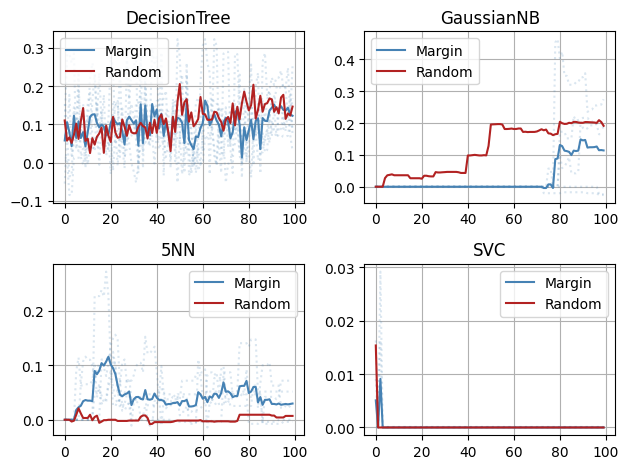

In [54]:
# %pdb 0
fig, axs = plt.subplots(2, 2,)
learners = ["DecisionTree", "GaussianNB", "5NN", "SVC"]

for learner, ax in zip(learners, axs.flatten()):

    ax.set_title(learner)
    margin_file = get_files(dataset_name, learner, 'margin_sampling')[0]
    margin_df = pd.read_csv(os.path.join(RESULTS_PATH,margin_file), index_col=0)
    
    random_file = get_files(dataset_name, learner, 'random_sampling')[0]
    random_df = pd.read_csv(os.path.join(RESULTS_PATH,random_file), index_col=0)

    compare_methods(ax, margin_df, random_df, method_label="Margin")
    
fig.tight_layout()

## Testando outros números execuções

### 25 execuções (5x5 fold)

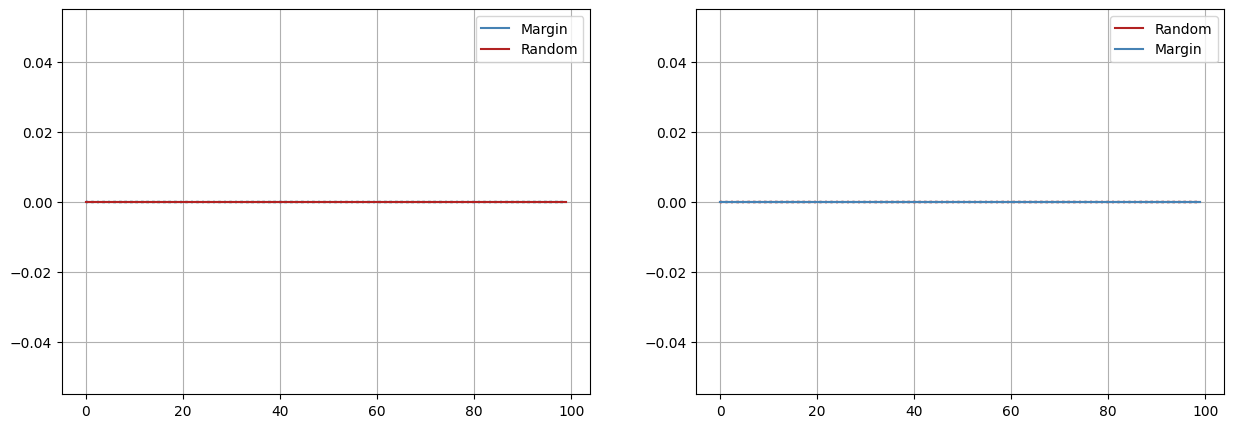

In [55]:
margin_file, random_file = !ls *.csv | grep $dataset_name |grep _5_

margin_df = pd.read_csv(margin_file, index_col=0)
random_df = pd.read_csv(random_file, index_col=0)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
compare_methods(ax[0], margin_df, random_df, method_label="Margin")
compare_methods(ax[1], random_df, margin_df, method_label="Random", baseline_label="Margin",baseline_color="steelblue", method_color="firebrick")

### 100 execuções (20x5 fold)

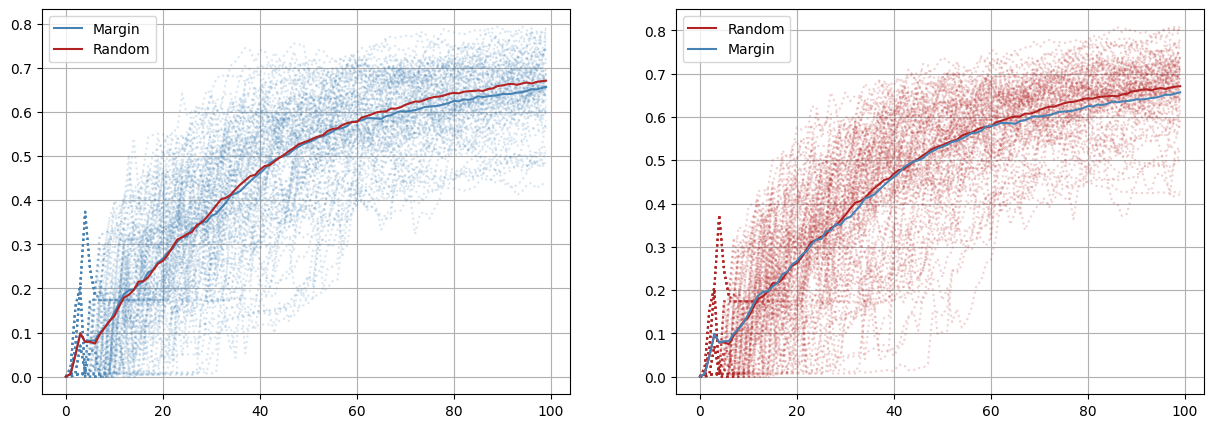

In [48]:
margin_file, random_file = !ls *.csv | grep $dataset_name |grep _20_

margin_df_100 = pd.read_csv(margin_file, index_col=0)
random_df_100 = pd.read_csv(random_file, index_col=0)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
compare_methods(ax[0], margin_df_100, random_df_100, method_label="Margin")
compare_methods(ax[1], random_df_100, margin_df_100, method_label="Random", baseline_label="Margin",baseline_color="steelblue", method_color="firebrick")

## Testando capacidade de sumarização de amostragens

In [49]:
def test_sample_size(sample_size, df1, df2):
    fig, axs = plt.subplots(1, 2, figsize=(15,5) )

    for ax, flag in zip(axs, (1, 0)): 
    
        ax.plot(df1.mean(axis=1), label="Margin")
        ax.plot(df2.mean(axis=1), label="Random", color="firebrick")

        for _ in range(5):
            if flag:
                samples = df1.sample(sample_size, axis=1)
                ax.plot(samples.mean(axis=1), "--", alpha=0.3, color="steelblue")
            else:
                samples = df2.sample(sample_size, axis=1)
                ax.plot(samples.mean(axis=1), "--", alpha=0.3, color="firebrick")
    
        ax.legend()
        ax.grid()

import ipywidgets as widgets
from IPython.display import display


widgets.interact(test_sample_size,
                 sample_size=widgets.IntSlider(min=5, max=100, step=5, value=5),
                 df1=widgets.fixed(margin_df_100),df2=widgets.fixed(random_df_100))

interactive(children=(IntSlider(value=5, description='sample_size', min=5, step=5), Output()), _dom_classes=('…

<function __main__.test_sample_size(sample_size, df1, df2)>